###  Car Price Modeling Project

* Part 1 - Predict price with car metadata

* Part 2 - Predict price with metadata + image

* Details:  Get metadata from craigslist API.  Get additional relevant features, like gas price.  
  Clean data.  Put clean data in SQLite database.

### `Research Notes`

In [1]:
#KEY FEATURES
#price label, brand, model, age, horsepower/engine_type, mileage. time passage from ad post?

#SECONDARY FEATURES
#make, fuel type, mpg, exterior color, door number, transmission type,
#dimensions, safety, air condition, interior, navigation y/n, engine type
#cubic capacity, number of ad views, power steering, rim type
#registered city, number of doors, 4WD, damaged, leather, alarm,
#A/C, parking sensors, xenon lights, remote unlock, electric mirrors,
#seat heat, moon roof, cruise control, abs, traction control

#OTHER FEATURES
#estimated car life, price rank as category (cheap, moderate, expensive)

#Non-craigslist features
# gas price,

#Sparse features to ignore?: damaged, city

In [2]:
#FEATURE ENHANCEMENT:
#Train with stratified sample of make
#Encode Thumbs Up/Down fields: [ON, OFF, NotAvailable] -> [1, -1, 0]
#Poly features for regression.  Ex. Mileage and year
#Differencing features and explicit features for orest.

In [3]:
# Candidate models
# Regression, KNN, SVM, random forest, naive bayes, neural networks
# Neural network should be best, followed by RF and SVM.

In [4]:
# Frame as Price as Regression vs Classification Problem
# Classification: bin continuous features using cluster analysis?

###  Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [6]:
%pwd

'C:\\Users\\Justin\\DATA_SCIENCE\\car_price_prediction'

In [7]:
#Import json and remove certain whitespace
vehicle=pd.read_json('ford_vehicle.json')
#vehicle.to_csv('ford_vehicle.csv')
vehicle['SubLoc'] = vehicle['SubLoc'].str.strip()

In [8]:
#These vehs aren't in Houston.  Drop them.
vehicle[vehicle['SubLoc'] == '(TRUCKMAX)']
drop_indices = vehicle[vehicle['SubLoc'] == '(TRUCKMAX)'].index
print('Drop indices for TRUCKMAX:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop indices for TRUCKMAX: Int64Index([ 146,  158,  267,  375,  396,  436,  500,  752,  763,  771,  851,
             867,  877,  945,  962, 1069, 1093, 1230, 1279, 1325, 1327, 1354,
            1399, 1433, 1510, 1665, 1679, 1697, 1715, 1740, 1840, 1966, 1985,
            1989, 2020, 2031, 2040, 2080, 2215, 2304, 2343, 2359, 2409, 2422,
            2540, 2687, 2706, 2712, 2727, 2736, 2808, 2877, 2896, 2935],
           dtype='int64')


In [9]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [10]:
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def train_and_valid(what_model, num_folds, X, y):
    fold_rsme=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):                         #split train data excluding holdout
        #Clone is copy of model not yet fit on any data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns

        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rsme.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 3))
    return fold_rsme, clone_model

In [11]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))
vehicle.insert(2,'Year',np.nan)
vehicle.insert(3,'Year_in_Title',np.nan)
vehicle.insert(4,'RawMake',np.nan)
vehicle.insert(5,'Make',np.nan)
vehicle.insert(6,'Model',np.nan)
vehicle.insert(7,'Trim',np.nan)
vehicle.insert(9,'LN_Price',np.nan)
vehicle.insert(10,'Seller',np.nan)
vehicle.head(3)

vehicle length: 2943
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Year,Year_in_Title,RawMake,Make,Model,Trim,Price,LN_Price,Seller,SubLoc,AttribDictionary,ImageDictionary
0,https://houston.craigslist.org/ctd/d/houston-2...,2013 FORD F-250 SD,NaN,NaN,NaN,NaN,NaN,NaN,$12950,NaN,NaN,(Hobby Area),{'0': '<span><b>2013 Ford F-250 SD</b></span>'...,{'0': 'https://images.craigslist.org/01414_au7...
1,https://houston.craigslist.org/cto/d/houston-2...,2013 Ford Expedition Limited,NaN,NaN,NaN,NaN,NaN,NaN,$10800,NaN,NaN,None,{'0': '<span><b>2013 Ford Expedition</b></span...,{'0': 'https://images.craigslist.org/00r0r_2QE...
2,https://houston.craigslist.org/ctd/d/houston-1...,'11 Ford F150 FX4 SuperCrew🔥 AWD PickUp Truck❗...,NaN,NaN,NaN,NaN,NaN,NaN,$1000,NaN,NaN,"(In House Finance starting @ $1,000 DOWN! NO B...","{'0': '<span><b>2011 ford f-150</b></span>', '...",{'0': 'https://images.craigslist.org/00S0S_6sD...


In [12]:
vehicle.loc[0, 'AttribDictionary']

{'0': '<span><b>2013 Ford F-250 SD</b></span>',
 '1': '<span>VIN: <b>1FT7X2A68DEA99152</b></span>',
 '2': '<span>condition: <b>excellent</b></span>',
 '3': '<span>cylinders: <b>8 cylinders</b></span>',
 '4': '<span>fuel: <b>gas</b></span>',
 '5': '<span>odometer: <b>125142</b></span>',
 '6': '<span>paint color: <b>white</b></span>',
 '7': '<span>size: <b>full-size</b></span>',
 '8': '<span>title status: <b>clean</b></span>',
 '9': '<span>transmission: <b>automatic</b></span>',
 '10': '<span>type: <b>pickup</b></span>'}

In [13]:
for k in vehicle.loc[0, 'AttribDictionary'].keys():
    print(k)

0
1
2
3
4
5
6
7
8
9
10


In [14]:
vehicle.loc[0, 'AttribDictionary'][str(5)]

'<span>odometer: <b>125142</b></span>'

In [15]:
vehicle.loc[0, 'AttribDictionary'].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [16]:
len(vehicle.loc[0, 'AttribDictionary'].keys())

11

In [17]:
#Extract any Odometer from AttribDictionary.
rawOdometer=[]

for idx in vehicle.index:
    success_flag = 0
    
    for k in vehicle.loc[idx, 'AttribDictionary'].keys():
        m = re.search('<span>odometer: <b>(\d+)', vehicle.loc[idx, 'AttribDictionary'][str(k)]) #re.search(pattern, string) gets first match
        
        if m is not None:
            success_flag = 1
            rawOdometer.append(m.group(1))
            
    if success_flag != 1:
        rawOdometer.append(np.nan)

vehicle['Odometer'] = rawOdometer
vehicle['Odometer'] = vehicle['Odometer'].astype('float')

In [50]:
vehicle['Odometer'].isna().sum()

618

In [51]:
vehicle['Odometer'].describe()

count      1815.000000
mean     111704.236915
std       61686.423086
min           0.000000
25%       66550.000000
50%      110000.000000
75%      149105.000000
max      719364.000000
Name: Odometer, dtype: float64

In [18]:
#Create dealer/owner features using URL_vehicle.
vehicle['Seller']=vehicle['URL_Vehicle'].str.extract('(ct[o|d])')
vehicle['Seller']=vehicle['Seller'].str.replace('ctd', 'dealer')
vehicle['Seller']=vehicle['Seller'].str.replace('cto', 'owner')

In [19]:
vehicle.loc[0:3, 'AttribDictionary']

0    {'0': '<span><b>2013 Ford F-250 SD</b></span>'...
1    {'0': '<span><b>2013 Ford Expedition</b></span...
2    {'0': '<span><b>2011 ford f-150</b></span>', '...
3    {'0': '<span><b>2003 Ford</b></span>', '1': '<...
Name: AttribDictionary, dtype: object

In [20]:
#Build Year column from AttribDictionary and verify numeric format. 
yrList=[]
for idx in vehicle.index:
    m = re.search('(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  #group(1) returns first parenthesized subgroup
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('Int64')

#Keep Years 1999 and later.
filt = (vehicle['Year'] >= 1999)
vehicle = vehicle[filt]

assert vehicle['Year'].dtypes == 'Int64',  "Year must be a nullable integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

In [21]:
#Extract RawMake col from AttribDictionary.
rawMakeList=[]

for idx in vehicle.index:
    m = re.search('<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [22]:
#Extract Make col from RawMake col.

#Regex patter
patt='\d*\s{0,2}\d+\s{1,2}(\w+)\s{0,2}(\w*-?[a-z]?)\s{0,2}(\w*-?[a-z]?)'

#Regex patter in verbose (re.X) format.
pattVerbose=re.compile(r'''\d*\s{0,2}         # 0 or more digits and 0-2 spaces
                           \d+\s{1,2}         # 1 or more digits and 1-2 spaces
                           (\w+)              # 1 or more words
                           \s{1,2}            # 1-2 whitespaces
                           (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
                           \s{0,2}            # 0-2 whitespaces
                           (\w*-?[0-9|a-z]*)  # 0 or more words, 0 or 1 "-", 0 or more numbers/letters
                        ''', re.X)

makeList=[]
for idx in vehicle.index:
    m = re.search(pattVerbose, vehicle.loc[idx, 'RawMake']) #re.search(pattern, string) gets first match
    if m is not None:
        makeList.append([m.group(1).lower(), m.group(2).lower(), m.group(3).lower()])
    else:
        #print('Missing Make/Model index:', idx)
        makeList.append(['None', 'None', 'None'])
                 
vehicle['Make']=[item[0] for item in makeList]
vehicle['Model']=[item[1] for item in makeList]
vehicle['Trim']=[item[2] for item in makeList]

In [23]:
vehicle.head(5)

,URL_Vehicle,Title,Year,Year_in_Title,RawMake,Make,Model,Trim,Price,LN_Price,Seller,SubLoc,AttribDictionary,ImageDictionary,Odometer
0,https://houston.craigslist.org/ctd/d/houston-2...,2013 FORD F-250 SD,2013,NaN,2013 ford f-250 sd,ford,f-250,sd,$12950,NaN,dealer,(Hobby Area),{'0': '<span><b>2013 Ford F-250 SD</b></span>'...,{'0': 'https://images.craigslist.org/01414_au7...,125142.0
1,https://houston.craigslist.org/cto/d/houston-2...,2013 Ford Expedition Limited,2013,NaN,2013 ford expedition,ford,expedition,,$10800,NaN,owner,None,{'0': '<span><b>2013 Ford Expedition</b></span...,{'0': 'https://images.craigslist.org/00r0r_2QE...,NaN
2,https://houston.craigslist.org/ctd/d/houston-1...,'11 Ford F150 FX4 SuperCrew🔥 AWD PickUp Truck❗...,2011,NaN,2011 ford f-150,ford,f-150,,$1000,NaN,dealer,"(In House Finance starting @ $1,000 DOWN! NO B...","{'0': '<span><b>2011 ford f-150</b></span>', '...",{'0': 'https://images.craigslist.org/00S0S_6sD...,127181.0
3,https://houston.craigslist.org/ctd/d/houston-c...,CASH FOR YOUR JUNK CARS 📲346-775-0733 WE BUY/ ...,2003,NaN,2003 ford,None,None,None,$1000,NaN,dealer,(WE PAY BETTER THAN THE REST !!🌞🌞🌞),"{'0': '<span><b>2003 Ford</b></span>', '1': '<...",{'0': 'https://images.craigslist.org/00E0E_dU7...,NaN
4,https://houston.craigslist.org/ctd/d/houston-l...,Low Down $800! Bad Credit? 2011 Ford Expedition,2011,NaN,2011 ford expedition,ford,expedition,,$800,NaN,dealer,(700 W 11th St),{'0': '<span><b>2011 ford expedition</b></span...,{'0': 'https://images.craigslist.org/00t0t_fmc...,118000.0


In [24]:
#Drop Make = 'None'
filt = (vehicle['Make'] == 'None')
drop_indices = vehicle[filt].index
print('Drop Make is None rows:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop Make is None rows: Int64Index([   3,  103,  513,  526,  529,  646,  765,  824,  854,  898, 1037,
            1041, 1080, 1082, 1092, 1238, 1350, 1658, 1816, 1993, 2027, 2144,
            2270, 2369, 2848, 2899],
           dtype='int64')


In [25]:
#Scrub Price - remove any $, periods, and spaces.  Note:  ORDER IS IMPORTANT!!!
vehicle['Price']=vehicle['Price'].str.replace('\,', '')
vehicle['Price']=vehicle['Price'].str.replace('\.00', '')
vehicle['Price']=vehicle['Price'].str.replace('\.0', '')
vehicle['Price']=vehicle['Price'].str.replace('\$', '')
vehicle['Price']=vehicle['Price'].str.replace('-', '')
vehicle['Price']=vehicle['Price'].str.replace(' ', '')
vehicle['Price']=vehicle['Price'].str.replace('\.', 'None')

In [26]:
vehicle.head(2)

,URL_Vehicle,Title,Year,Year_in_Title,RawMake,Make,Model,Trim,Price,LN_Price,Seller,SubLoc,AttribDictionary,ImageDictionary,Odometer
0,https://houston.craigslist.org/ctd/d/houston-2...,2013 FORD F-250 SD,2013,NaN,2013 ford f-250 sd,ford,f-250,sd,12950,NaN,dealer,(Hobby Area),{'0': '<span><b>2013 Ford F-250 SD</b></span>'...,{'0': 'https://images.craigslist.org/01414_au7...,125142.0
1,https://houston.craigslist.org/cto/d/houston-2...,2013 Ford Expedition Limited,2013,NaN,2013 ford expedition,ford,expedition,,10800,NaN,owner,None,{'0': '<span><b>2013 Ford Expedition</b></span...,{'0': 'https://images.craigslist.org/00r0r_2QE...,NaN


In [27]:
#Price is missing or None.  Drop corresponding rows.
filt = (vehicle['Price'].isna()) | (vehicle['Price'] == 'None') | (vehicle['Price'] == '')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} missing price rows:', drop_indices, '\n')
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Make isn't 'ford'.  Drop corresponding rows.
filt = (vehicle['Make'] != 'ford')
drop_indices = vehicle[filt].index
print(f'Drop {len(drop_indices)} non-ford makes:', drop_indices)
vehicle.drop(index = drop_indices, inplace = True, errors = 'ignore')

#Cast Price as float.
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

Drop 308 missing price rows: Int64Index([  17,   18,   19,   22,   33,   34,   46,   47,   48,   55,
            ...
            2947, 2948, 2953, 2970, 2977, 2988, 2990, 2991, 2993, 2995],
           dtype='int64', length=308) 

Drop 3 non-ford makes: Int64Index([163, 1102, 2720], dtype='int64')


In [28]:
from scipy import stats
from scipy.stats import norm

def normalize_feature(df, bad_feature):
    
    #Make histogram & normal probability plot
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
    ax1.set_title(f'{bad_feature} Histogram - Not Normal Distribution')
    res=stats.probplot(df[bad_feature], dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')

    #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
    #Exponential equation to undo normpr: e^normFeat-1=feature
    log_feat=np.log(df[bad_feature]+1)
        
    #Plots after normalization
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
    ax1.set_title(bad_feature+' Histogram - Normal Distribution')
    res=stats.probplot(log_feat, dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')
    return log_feat

**** No Fit improvement from LN transform of price. ****


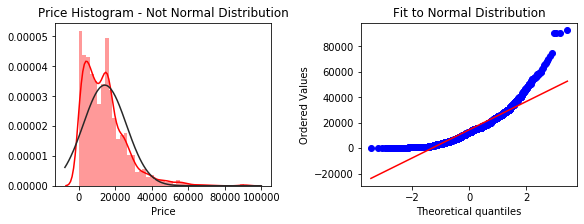

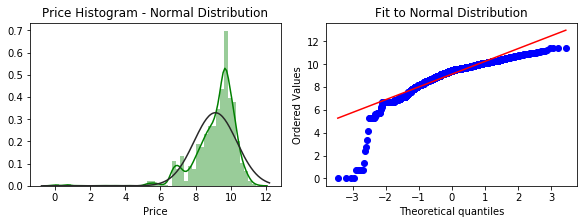

In [29]:
vehicle['LN_Price'] = normalize_feature(df=vehicle, bad_feature='Price')
print('**** No Fit improvement from LN transform of price. ****')

In [30]:
#Fix Model spelling
model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'f150' : 'f-150',
                      'f250' : 'f-250', 
                      'f350' : 'f-350', 
                      'f450' : 'f-450'}
            }

vehicle.replace(model_dict, inplace=True)

#Remove vehicle 'Model' counts under 50.  Save to vehs.
model_counts=vehicle['Model'].value_counts()             #get model freq
models_over_50 = model_counts[model_counts >= 50].index  #get 50+ model names
vehs = vehicle[vehicle['Model'].isin(models_over_50)].copy() #boolean filter for the 50+ model names
vehs['Model'].value_counts()

f-150         730
f-250         235
mustang       192
expedition    142
fusion        124
explorer      119
f-350         116
transit       104
escape        101
focus          96
edge           84
super          73
Name: Model, dtype: int64

In [31]:
#Drop prices under $100 or over $60,000
drop_indices=vehs[(vehs['Price'] < 100) | (vehs['Price'] > 60000)].index

print(f'Drop {len(drop_indices)} prices ouside $100 - $60,000:', drop_indices)
vehs.drop(index = drop_indices, inplace = True, errors = 'ignore')

Drop 22 prices ouside $100 - $60,000: Int64Index([  71,  140,  331,  420,  426,  629, 1113, 1344, 1349, 1395, 1534,
            1535, 1634, 1726, 2124, 2283, 2340, 2659, 2764, 2778, 2785, 2833],
           dtype='int64')


In [32]:
def flag_outliers(df, filt_col, filt_val, col_to_flag):
    ''' Flag likely outliers for the target col_to_flag and filt_val.'''
    filtSer=df.loc[df[filt_col] == filt_val, col_to_flag].copy()
    three_std = 3 * filtSer.std()
    avg = filtSer.mean()
    lower_lim = avg - three_std
    upper_lim = avg + three_std
    print(' average:', round(avg,1), '\n', 'lower_lim:', round(lower_lim,1), '\n', 'upper_lim:', round(upper_lim,1))
    
    outside_lim=[]
    for idx in filtSer.index:      
        price = filtSer.loc[idx]        
        if price > upper_lim or price < lower_lim:
            outside_lim.append([idx, col_to_flag, price])     
    return outside_lim, upper_lim, lower_lim

out_lim, u_lim, l_lim = flag_outliers(df=vehs, filt_col='Year', filt_val=2008, col_to_flag='Price')               
display(out_lim)

 average: 10061.6 
 lower_lim: -8192.3 
 upper_lim: 28315.5


[[2075, 'Price', 41990.0]]

In [33]:
vehs.loc[2075]

URL_Vehicle         https://houston.craigslist.org/ctd/d/irving-20...
Title               2008 Ford F550 1-Owner ETI ETC 37 IH 42' WH Di...
Year                                                             2008
Year_in_Title                                                     NaN
RawMake                                2008 ford super duty f-550 drw
Make                                                             ford
Model                                                           super
Trim                                                             duty
Price                                                           41990
LN_Price                                                      10.6452
Seller                                                         dealer
SubLoc              (*2008* *Ford* *F550* *1-Owner* *ETI* *ETC* *3...
AttribDictionary    {'0': '<span><b>2008 Ford Super Duty F-550 DRW...
ImageDictionary     {'0': 'https://images.craigslist.org/00K0K_hMG...
Odometer            

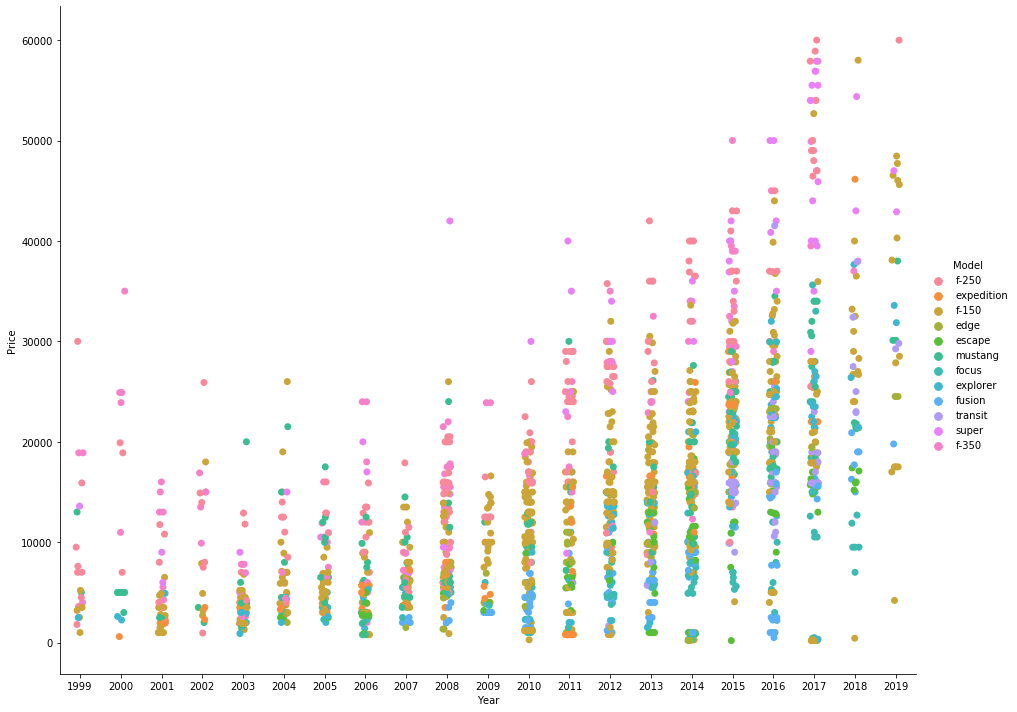

In [34]:
#Catplot by Year, Price, and Model
sns.catplot(x='Year',y='Price',hue='Model', data=vehs, height=10, aspect=1.3, s=7)  #s changes marker size
plt.show()

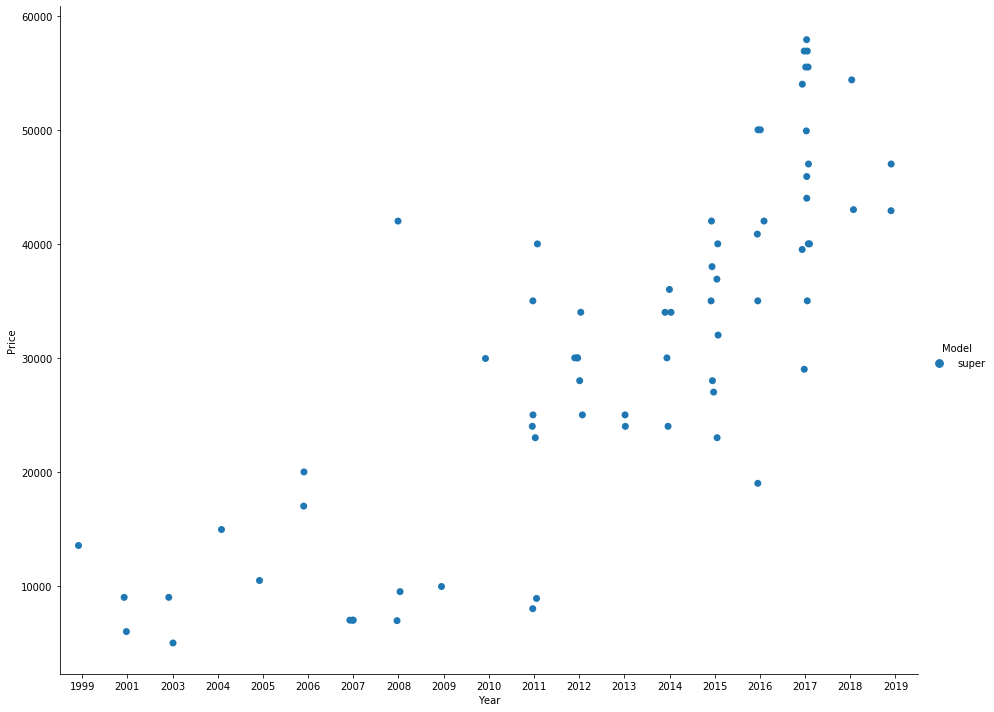

In [35]:
#Catplot by Year, Price, and Selected Model
sns.catplot(x='Year',y='Price',hue='Model', data=vehs[vehs['Model']=='super'], height=10, aspect=1.3, s=7)  #s changes marker size
plt.show()

In [36]:
vehs[(vehs['Model'] == 'f-250') & (vehs['Year'] == 1999)].sort_values(by='Price', ascending=False)[0:3]

,URL_Vehicle,Title,Year,Year_in_Title,RawMake,Make,Model,Trim,Price,LN_Price,Seller,SubLoc,AttribDictionary,ImageDictionary,Odometer
822,https://houston.craigslist.org/ctd/d/houston-1...,1999 Ford F-250 F250 F 250 XLT 7.3L Powerstrok...,1999,NaN,1999 ford f-250 f250 f 250,ford,f-250,f250,29995.0,10.308819,dealer,(Diesel of Houston),{'0': '<span><b>1999 Ford F-250 F250 F 250</b>...,{'0': 'https://images.craigslist.org/00m0m_aaR...,14380.0
2442,https://houston.craigslist.org/ctd/d/houston-1...,1999 Ford F-250 ExCab LB 7.3L Diesel 6-SP Manu...,1999,NaN,1999 ford f-250,ford,f-250,,15900.0,9.674137,dealer,(RBP AUTOMOTIVE INC),"{'0': '<span><b>1999 Ford F-250</b></span>', '...",{'0': 'https://images.craigslist.org/00u0u_96o...,185597.0
1603,https://houston.craigslist.org/cto/d/wharton-f...,1999.5 F250 4 Door Long Bed DIESEL,1999,NaN,1999 ford f250 super duty,ford,f-250,super,9500.0,9.159152,owner,(Wharton),{'0': '<span><b>1999 ford f250 super duty</b><...,{'0': 'https://images.craigslist.org/00s0s_cVj...,297000.0


In [37]:
vehs[(vehs['Model'] == 'f-350') & (vehs['Year'] == 2000)].sort_values(by='Price', ascending=False)[0:3]

,URL_Vehicle,Title,Year,Year_in_Title,RawMake,Make,Model,Trim,Price,LN_Price,Seller,SubLoc,AttribDictionary,ImageDictionary,Odometer
1244,https://houston.craigslist.org/cto/d/gardena-f...,F350 Dully Diesel,2000,NaN,2000 ford f-350,ford,f-350,,35000.0,10.463132,owner,None,"{'0': '<span><b>2000 Ford F-350</b></span>', '...",{'0': 'https://images.craigslist.org/00n0n_fpX...,NaN
1139,https://houston.craigslist.org/ctd/d/houston-2...,2000 Ford F350 CrewCab LongBed 7.3L Diesel 4x4...,2000,NaN,2000 ford f-350,ford,f-350,,24900.0,10.122663,dealer,(RBP Automotive Inc),"{'0': '<span><b>2000 Ford F-350</b></span>', '...",{'0': 'https://images.craigslist.org/00000_34f...,109297.0
2428,https://houston.craigslist.org/ctd/d/houston-2...,2000 Ford F350 CrewCab LongBed 7.3L Diesel 4x4...,2000,NaN,2000 ford f-350,ford,f-350,,24900.0,10.122663,dealer,(RBP Automotive Inc),"{'0': '<span><b>2000 Ford F-350</b></span>', '...",{'0': 'https://images.craigslist.org/00000_34f...,109297.0


In [38]:
#Reset vehs dataframe indices.
#vehs.reset_index(drop=True, inplace=True)

#Build train and test, stratified by Model.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=22)
for train_index, test_index in sss.split(vehs, vehs['Model']):
    train = vehs.iloc[train_index]
    test = vehs.iloc[test_index]

In [39]:
#Drop some features
train = train.drop(['URL_Vehicle', 'Title', 'Year_in_Title', 'LN_Price', 'SubLoc', 'AttribDictionary', 'ImageDictionary', 'RawMake'],
           axis='columns', errors='ignore')

test = test.drop(['URL_Vehicle', 'Title', 'Year_in_Title', 'LN_Price', 'SubLoc', 'AttribDictionary', 'ImageDictionary', 'RawMake'],
           axis='columns', errors='ignore')
display('train:', train.head(2))
display('test:', test.head(2))

'train:'

,Year,Make,Model,Trim,Price,Seller,Odometer
2355,2014,ford,focus,,7995.0,dealer,88101.0
1361,2008,ford,expedition,,7995.0,dealer,133269.0


'test:'

,Year,Make,Model,Trim,Price,Seller,Odometer
69,2014,ford,super,duty,33991.0,dealer,138030.0
2164,2008,ford,f-150,,7500.0,owner,172400.0


In [40]:
#One-Hot Encode train and test.
categ_cols= ['Year', 'Make', 'Model', 'Trim', 'Seller']
ohe_train_df, ohe_test_df = one_hot_encode(train_df=train, test_df=test, cat_cols=categ_cols)

In [41]:
#Drop original category columns.  Add OHE category columns.
train = train.drop(columns=categ_cols, axis='columns', errors='ignore')
test = test.drop(columns=categ_cols, axis='columns', errors='ignore')

train = pd.concat([train, ohe_train_df], axis='columns')
test = pd.concat([test, ohe_test_df], axis='columns')
display('train:', train.head(2))
display('test:', test.head(2))

'train:'

,Price,Odometer,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_focus,Model_fusion,Model_mustang,Model_super,Model_transit,Trim_,Trim_1-owner,Trim_150,Trim_2013,Trim_2015,Trim_2016,Trim_250,Trim_2wd,Trim_4dr,Trim_4wd,Trim_4x4,Trim_6,Trim_base,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_cobra,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_diesel,Trim_duty,Trim_ecoboost,Trim_eddie,Trim_el,Trim_extended,Trim_f250,Trim_f350,Trim_flatbed,Trim_fx2,Trim_fx4,Trim_gt,Trim_harley,Trim_harley-davidson,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_lariat,Trim_limited,Trim_ltd,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_raptor,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_ses,Trim_sh,Trim_sport,Trim_st,Trim_stx,Trim_super,Trim_supercrew,Trim_superduty,Trim_svt,Trim_sxt,Trim_súper,Trim_t-250,Trim_t-350,Trim_titanium,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Seller_dealer,Seller_owner
2355,7995.0,88101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1361,7995.0,133269.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


'test:'

,Price,Odometer,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Make_ford,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_focus,Model_fusion,Model_mustang,Model_super,Model_transit,Trim_,Trim_1-owner,Trim_150,Trim_2013,Trim_2015,Trim_2016,Trim_250,Trim_2wd,Trim_4dr,Trim_4wd,Trim_4x4,Trim_6,Trim_base,Trim_bucket,Trim_bullitt,Trim_cargo,Trim_cobra,Trim_connect,Trim_convertible,Trim_coupe,Trim_crew,Trim_crewcab,Trim_diesel,Trim_duty,Trim_ecoboost,Trim_eddie,Trim_el,Trim_extended,Trim_f250,Trim_f350,Trim_flatbed,Trim_fx2,Trim_fx4,Trim_gt,Trim_harley,Trim_harley-davidson,Trim_hybrid,Trim_king,Trim_kingranch4x4crewdiesel,Trim_lariat,Trim_limited,Trim_ltd,Trim_passenger,Trim_pickup,Trim_platinum,Trim_powerstroke,Trim_premium,Trim_raptor,Trim_regular,Trim_rs,Trim_s,Trim_saleen,Trim_sd,Trim_se,Trim_sel,Trim_ses,Trim_sh,Trim_sport,Trim_st,Trim_stx,Trim_super,Trim_supercrew,Trim_superduty,Trim_svt,Trim_sxt,Trim_súper,Trim_t-250,Trim_t-350,Trim_titanium,Trim_v6,Trim_van,Trim_wagon,Trim_x,Trim_xl,Trim_xls,Trim_xlt,Seller_dealer,Seller_owner
69,33991.0,138030.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2164,7500.0,172400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
#Create trainX, trainY, testX, and testY
trainX = train.copy()
trainY =trainX.pop('Price')
#trainY =trainX.pop('LN_Price')
testX = test.copy()
testY = testX.pop('Price')
#testY = testX.pop('LN_Price')

In [43]:
# #Review noise features - where one category is nearly all observations.

# noise_feat = []
# pct_zeros = .999
# for i in trainX.columns:
#     counts = trainX[i].value_counts()
#     zeros = counts.iloc[0]  #top frequency category    
#     if zeros / len(trainX) > pct_zeros:
#         noise_feat.append(i)

# print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###')
# print(f'### Noise Features: {noise_feat}  ###\n')

# for c in trainX.columns:
#     counts = trainX[c].value_counts()
#     zeros = counts.iloc[0]  #top frequency category
#     print('Count nonzero -', (len(trainX[c]) - zeros),':')
#     plt.figure(figsize=[4,4])
#     plt.scatter(trainX[c], trainY)
#     plt.title(f'{c} vs Price'); plt.xlabel(f'{c}'); plt.ylabel('Price');
#     plt.show()

# #Drop noise features.  Will help non-regularized models by reducing dimensionality.
# trainX = trainX.drop(columns=noise_feat, axis='columns', errors='ignore')
# testX = testX.drop(columns=noise_feat, axis='columns', errors='ignore')

## `Tune Models with Cross Validation`

In [44]:
#Train and Score LR CV
lr=LinearRegression(fit_intercept=False)
fold_rsme, linMod = train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## LR R^2:', round(linMod.score(trainX, trainY),3))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#Train and Score Ridge CV
ridge=Ridge(alpha=0.1, solver='cholesky')
fold_rsme, ridgeMod = train_and_valid(what_model=ridge, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## ridge R^2:', round(ridgeMod.score(trainX, trainY),3))

## `Predict`

In [ ]:
linregr=LinearRegression(fit_intercept=False)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_linregr)), 4)
print('test RMSE:', RMSE)
print('test R^2 test:', round(linregr.score(testX, testY),4))

In [ ]:
rr=Ridge(alpha=.1, solver='cholesky')  #no scaling required for closed-form solution
rr.fit(trainX, trainY)
y_pred_rr=rr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_rr)), 4)
print('test RMSE:', RMSE)
print('test R^2:', round(rr.score(testX, testY),4))

### *Need more data to improve predictions!*

* Pick for sale by all (owner or dealer) rather than just owner.  DONE.
* Combine Houston with College Station and Galveston?
* Pick more common manufacturer.  DONE.
* Using Natural Log price.  DONE -- DOES **NOT** HELP

In [ ]:
#Existing data is Honda for sale by Owner
print('train (rows,cols):', trainX.shape)
print('test (rows,cols):', testX.shape)

In [ ]:
#*********************************UNUSED CODE**************************************

# #Extract Year_in_Title from vehicle Title and save off column - pandas.Series.str.extract

# patt='(\d+)'
# vehicle['Year_in_Title'] = vehicle['Title'].str.extract(patt).replace(np.nan, 'None')

# def fix_2digit(row):
#     if len(row) == 4 or row == 'None':
#         return row
#     elif row in [str(dig).zfill(2) for dig in range(0,21)]:    #Assume 00 - 20 is 2000s
#         return '20' + row
#     elif row in [str(dig).zfill(2) for dig in range(21,100)]:  #Assume 21 - 99 is 1900s
#         return '19' + row
#     else:
#         return 'None'
    
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].apply(fix_2digit)
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].replace('None',np.nan).astype('float').astype('Int64')
# vehicle['Year_in_Title'].value_counts(dropna=False)

#re.search('<b>(\d*\s{0,2})(\d+\s{1,2}\w+\s{1,2}\w+\s{0,2}\w*)</b>', vehicle.loc[55, 'AttribDictionary']['0']).group(0)